<a href="https://colab.research.google.com/github/LaurenzWerschmann/PDS/blob/main/NLP_PROJECT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Capstone Project: Question & Answering with NLP

**Main tasks:**

*   Generate a Q&A dataset by creating text descriptions for the questionnaires provided by snapADDY
*   Apply QA-models
*   Evaluate different QA pre-trained models on generated dataset

 **Extra tasks:**

*   Dashboard
*   Generating new questions, mixing existing questions
*   Using two different datasets (Chat GPT 4 vs Gemini)
*   Text classification

##**Attention!** Datasets must be loaded separately into the notebook. The documents are included in the submission. They must be placed under "content" in the notebook for all models to function properly.

## Preparation

To begin, we import the necessary packages to work on the project.

In [ ]:
!pip install transformers torch
!pip install transformers torch datasets
!pip install evaluate
!pip install gradio
!pip install scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 26.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 80.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 38.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 80.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitl

In [ ]:
import json
import pandas as pd
import time
import torch
import random
import gc
import evaluate
import gradio as gr

from transformers import pipeline
from collections import defaultdict
from transformers import BertTokenizer, BertForQuestionAnswering, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from datasets import Dataset
from transformers import BertForQuestionAnswering
from torch.utils.data import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForMultipleChoice,
    Trainer,
    TrainingArguments
)

##Generating a Q&A dataset with gemini

In the first phase of our project we used gemini via API to generate answers and labels. To do this, we loaded our prepared questionaries and transformed them into a data frame. Then we asked Gemini for answers and labels. Further documentation can be found in the project documentation.

In [ ]:
import json
import requests
import pandas as pd

# URL of the JSON file
url = "https://raw.githubusercontent.com/pauline187/archiv/main/questionnaire_after_contact_interaction.json"

# Fetch JSON data from the URL
response = requests.get(url)

# Check if the request was successful
if response.status_code == 200:
    data = response.json()  # Parse JSON content
    print("JSON file successfully loaded")
else:
    print(f"Error: Unable to fetch data, status code {response.status_code}")

with open('questionnaire.json', 'w', encoding='utf-8') as file:
    json.dump(data, file, indent=4)
print("JSON file saved locally as 'questionnaire.json'")

rows = []
for item in data:
    question_id = item['id']
    question_type = item['type']
    question_text = item['question']

    for option in item['options']:
        rows.append({
            'id': question_id,
            'type': question_type,
            'question': question_text,
            'option': option['option']
        })

# Save DataFrame
df_table= pd.DataFrame(rows)
# Check DataFrame
df_table.head(10)

JSON file successfully loaded
JSON file saved locally as 'questionnaire.json'


,id,type,question,option
0,aa2d8cdd-0758-4035-b0b6-ca18e2f380d8,SINGLE_SELECT,Do you consent to your Data being processed?,Yes
1,aa2d8cdd-0758-4035-b0b6-ca18e2f380d8,SINGLE_SELECT,Do you consent to your Data being processed?,No
2,12e1ed1d-edaa-4e93-8645-de3850e998f9,SINGLE_SELECT,In which Customer group is your contact?,End User
3,12e1ed1d-edaa-4e93-8645-de3850e998f9,SINGLE_SELECT,In which Customer group is your contact?,"Wholesaler, Distributor"
4,12e1ed1d-edaa-4e93-8645-de3850e998f9,SINGLE_SELECT,In which Customer group is your contact?,"Consultant, Planner, Architect"
5,12e1ed1d-edaa-4e93-8645-de3850e998f9,SINGLE_SELECT,In which Customer group is your contact?,R&D
6,625012ae-9192-4cf6-a73d-55e1813d6014,MULTI_SELECT,In which products is you contact interested in?,MY-SYSTEM
7,625012ae-9192-4cf6-a73d-55e1813d6014,MULTI_SELECT,In which products is you contact interested in?,Notion
8,625012ae-9192-4cf6-a73d-55e1813d6014,MULTI_SELECT,In which products is you contact interested in?,JTS
9,625012ae-9192-4cf6-a73d-55e1813d6014,MULTI_SELECT,In which products is you contact interested in?,JS EcoLine


In [ ]:
# Group by 'id' and 'question', aggregate 'option' values into lists
df_grouped = df_table.groupby(['id', 'type', 'question'])['option'].apply(list).reset_index()
df_grouped.head(25)


,id,type,question,option
0,034b7b45-2139-4b5f-8933-6b48dd732920,SINGLE_SELECT,What is the size of your contact's company?,"[1-10, 11-50, 51-200, 201-2000, larger than 2000]"
1,0407e2fa-e5d3-4464-a33e-210013621431,SINGLE_SELECT,What level of customer satisfaction did you co...,"[Very satisfied, Satisfied, Unsatisfied, Very ..."
2,0699fc5a-34a4-4160-bda1-fb135a3615da,MULTI_SELECT,Which kind of follow up is planned with your c...,"[Email, Phone, Schedule a Visit, No action]"
3,12e1ed1d-edaa-4e93-8645-de3850e998f9,SINGLE_SELECT,In which Customer group is your contact?,"[End User, Wholesaler, Distributor, Consultant..."
4,25f0cc40-a168-40f9-aef3-5d9956de4d11,SINGLE_SELECT,Which language is wanted for communication?,"[German, Italian, Japanese , English, Spanish]"
5,3dd27f03-db17-4608-8f99-158f5a7c7abf,NUMBER,What phone number can we use for contact?,[phone number]
6,3f34e5b3-1cb0-48ea-93d2-3f21b3371b5d,SINGLE_SELECT,Would your contact like to receive marketing i...,"[Yes, No]"
7,47466ef3-68cf-4cfa-aa2f-7e395ad4590f,SINGLE_SELECT,What is the size of the trade fair team of you...,"[1-5, 6-10, 11-15, 16-20, 21-30, 31-40, more t..."
8,56127ae3-c20b-4082-bfad-d6976bee7003,DATE,When does you contact wish to receive a follow...,[Date]
9,5aefc81d-c5d2-41fc-bc7b-6117d1c7671e,SINGLE_SELECT,What type of company does your contact work for?,"[Construction company, Craft enterprises, Scaf..."


In [ ]:
# Importing gemini
import google.generativeai as genai
from IPython.display import display, Markdown
from google.colab import userdata

# retrieving the key stored in Colab
key = userdata.get('GOOGLE_API_KEY')

# configure the key for calling GenAI model
genai.configure(api_key=key)

# load model
model = genai.GenerativeModel("gemini-1.5-flash")

In [ ]:
df_MC2 = df_grouped[df_grouped['type'] == 'MULTI_SELECT']
# Loop to get more answers
import time
# Empty list to store the results
responses = []

for run in range(20):
  # Loop through each row and generate a response
  for index, row in df_MC2.iterrows():
      prompt = f"""
      You are a sales representative at a trade show, trying to connect with people.
      You have a conversation with someone (please imagine the whole conversation)
      and then you fill out a questionnaire in an app, trying to remember as much
      as possible about the interaction you just had.

      The question you answer is: "{row['question']}"
      The options are: "{row['option']}".

      Give me only the context of why you chose an option or multiple options, not the option itself.

      """

      try:
          # Call the Gemini API to generate content
          response = model.generate_content(prompt)

          # Safely extract the answer text
          if response and response.text:
              answer = response.text.strip()
          else:
              answer = "Error: No response generated"

      except Exception as e:
          answer = f"Error generating response: {e}"

      # Save the question, options, and generated answer
      responses.append({
          'question': row['question'],
          'answer': answer,
          'label': row['option']
      })
      time.sleep(3)

# Convert the results to a DataFrame
df_MC_answers2 = pd.DataFrame(responses)

In [ ]:
df_MC_answers2.head(20)

,question,answer,label
0,Which kind of follow up is planned with your c...,He mentioned needing a solution by the end of ...,"[Email, Phone, Schedule a Visit, No action]"
1,In which products is you contact interested in?,He mentioned struggling with inventory managem...,"[MY-SYSTEM, Notion, JTS, JS EcoLine, AKW100, A..."
2,What is the contact person interested in?,He was initially drawn to our booth because of...,"[100 Additive Manufacturing, 200 Automation, 3..."
3,What is the type of the contact?,He mentioned his company was a distributor of ...,"[Existing customer, Supplier, New customer / P..."
4,What kind of solution is you contract searchin...,He mentioned struggling to keep his contact da...,"[Scan business cards, Clean up CRM, Extract da..."
5,In which products is your contact interested in?,He mentioned experiencing significant issues w...,"[Automotive radar target simulation, Noise fig..."
6,Who would you like to copy in the follow up?,Joachim Wagner is the CEO of their company and...,"[Stephan Maier, Joachim Wagner, Erik Schneider..."
7,What productinterests did you contact express?,He was very interested in improving the accura...,"[BusinessCards, DataEnrichment, VisitReport, D..."
8,When does the contact person wish to receive a...,"During our conversation, Mr. Henderson mentio...","[1 week, 2 weeks, 3 weeks]"
9,Which kind of follow up is planned with your c...,He mentioned needing a solution by the end of ...,"[Email, Phone, Schedule a Visit, No action]"


In [ ]:
df_MC_answers2.describe()

,question,answer,label
count,450,450,450
unique,9,450,9
top,Which kind of follow up is planned with your c...,He mentioned needing a solution by the end of ...,"[Email, Phone, Schedule a Visit, No action]"
freq,50,1,50


In [ ]:
error_count = df_MC_answers2['answer'].str.contains('Error', na=False).sum()
print(f"The error occurred {error_count} times.")

The error occurred 0 times.


In [ ]:
# Loop through each row and generate a response
classified_answers = []

for index, row in df_MC_answers2.iterrows():
    prompt = f"""
    You are an AI assistant tasked with classifying responses based on provided categories.

    Question: {row['question']}
    Answer: {row['answer']}

    Select the fitting categories from the following options:
    {row['label']}

    Return them in a list.
    """

    try:
        # Call the Gemini API to generate content
        response = model.generate_content(prompt)

        # Safely extract the answer text
        if response and response.text:
            classified_answer = response.text.strip()
        else:
            classified_answer = "Error: No response generated"

    except Exception as e:
        classified_answer = f"Error generating response: {e}"

    # Append the classified answer to the list
    classified_answers.append(classified_answer)

    # Introduce delay to avoid hitting rate limits
    time.sleep(3)

# Add the classified answers as a new column in the original DataFrame
df_MC_answers2['correct_label'] = classified_answers

KeyboardInterrupt: 

In [ ]:
error_count = df_MC_answers2['correct_label'].str.contains('error', na=False).sum()
print(f"The error occurred {error_count} times.")

The error occurred 4 times.


In [ ]:
df_MC_answers2.tail(20)

,question,answer,label
430,What productinterests did you contact express?,He mentioned struggling with inaccurate contac...,"[BusinessCards, DataEnrichment, VisitReport, D..."
431,When does the contact person wish to receive a...,"During our conversation, Mr. Jones mentioned ...","[1 week, 2 weeks, 3 weeks]"
432,Which kind of follow up is planned with your c...,"He mentioned being swamped with emails, so a p...","[Email, Phone, Schedule a Visit, No action]"
433,In which products is you contact interested in?,He mentioned struggling with inventory managem...,"[MY-SYSTEM, Notion, JTS, JS EcoLine, AKW100, A..."
434,What is the contact person interested in?,He was initially drawn to our booth because of...,"[100 Additive Manufacturing, 200 Automation, 3..."
435,What is the type of the contact?,He mentioned being involved in the agricultura...,"[Existing customer, Supplier, New customer / P..."
436,What kind of solution is you contract searchin...,He mentioned his team spends hours manually en...,"[Scan business cards, Clean up CRM, Extract da..."
437,In which products is your contact interested in?,He mentioned struggling with signal integrity ...,"[Automotive radar target simulation, Noise fig..."
438,Who would you like to copy in the follow up?,Joachim Wagner is our head of sales for the re...,"[Stephan Maier, Joachim Wagner, Erik Schneider..."
439,What productinterests did you contact express?,He was initially drawn to our booth because of...,"[BusinessCards, DataEnrichment, VisitReport, D..."


In [ ]:
df_MC_answers2.to_csv("df_MC_180.csv", index=False, encoding='utf-8')


##Evaluation of the Gemini dataset

We used BERT, RoBERTa, and DeBERTa to evaluate the Gemini dataset due to their strong individual capabilities and suitability for the task.

###RoBERTa

In [ ]:
# Install required libraries
!pip install torch torchvision torchaudio transformers datasets evaluate scikit-learn matplotlib seaborn --quiet

# IMPORTS
import pandas as pd
import torch
import numpy as np
import ast
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, AdamW
import evaluate
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from IPython.display import display

import os
os.environ["WANDB_DISABLED"] = "true"

# DATA LOADING
file_path = "/content/Gemini_multi.csv"
df = pd.read_csv(file_path)

df["label"] = df["label"].apply(ast.literal_eval)
df["correct_label"] = df["correct_label"].apply(ast.literal_eval)

unique_labels = sorted(set(label for sublist in df["label"] for label in sublist))
label2id = {label: i for i, label in enumerate(unique_labels)}
id2label = {i: label for label, i in label2id.items()}

def encode_labels(correct_labels, possible_labels):
    encoded = [0] * len(unique_labels)
    for label in correct_labels:
        if label in possible_labels:
            encoded[label2id[label]] = 1
    return encoded

df["encoded_labels"] = df.apply(lambda row: encode_labels(row["correct_label"], row["label"]), axis=1)

# Tokenizer für RoBERTa-Base
tokenizer = AutoTokenizer.from_pretrained("roberta-base")

class CustomDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        inputs = tokenizer(row["question"] + " " + row["answer"], truncation=True,
                           padding="max_length", max_length=512, return_tensors="pt")
        labels = torch.tensor(row["encoded_labels"], dtype=torch.float)
        return {
            "input_ids": inputs["input_ids"].squeeze(),
            "attention_mask": inputs["attention_mask"].squeeze(),
            "labels": labels
        }

train_size = int(0.8 * len(df))
train_df, test_df = df[:train_size], df[train_size:]

train_dataset = CustomDataset(train_df)
test_dataset = CustomDataset(test_df)

# Modell laden
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModelForSequenceClassification.from_pretrained(
    "roberta-base",
    num_labels=len(unique_labels),
    ignore_mismatched_sizes=True  # Falls das Modell für eine andere Anzahl an Labels trainiert wurde
).to(device)

# Lade die Metriken (Accuracy, Precision, Recall, F1-Score)
accuracy_metric = evaluate.load("accuracy")
precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")
f1_metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)

    accuracy = accuracy_metric.compute(predictions=predictions, references=np.argmax(labels, axis=1))
    precision = precision_metric.compute(predictions=predictions, references=np.argmax(labels, axis=1), average="macro")
    recall = recall_metric.compute(predictions=predictions, references=np.argmax(labels, axis=1), average="macro")
    f1 = f1_metric.compute(predictions=predictions, references=np.argmax(labels, axis=1), average="macro")

    return {
        "accuracy": accuracy["accuracy"],
        "precision": precision["precision"],
        "recall": recall["recall"],
        "f1": f1["f1"]
    }

# Training Arguments
training_args = TrainingArguments(
    output_dir="./results_roberta",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=3e-5,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    num_train_epochs=10,
    weight_decay=0.01,
    logging_dir="./logs_roberta",
    logging_steps=10,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="f1",  # Basierend auf F1-Score das beste Modell speichern
    report_to="none"
)

# Training mit `Trainer`
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# Modell trainieren
trainer.train()

# Evaluierung
results = trainer.evaluate()
print(results)

# ERSTELLE EINE TABELLE DER METRIKEN
metrics_df = pd.DataFrame.from_dict(results, orient="index", columns=["Value"])
display(metrics_df)

print("Training abgeschlossen – Metriken für 'roberta-base' gespeichert!")

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-4-6cc0b27e9e07>:116: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.248500,0.222213,0.000000,0.000000,0.000000,0.000000
2,0.182500,0.178863,0.000000,0.000000,0.000000,0.000000
3,0.165800,0.159827,0.055556,0.059524,0.059524,0.038095
4,0.133500,0.140256,0.138889,0.091270,0.107143,0.073469
5,0.122500,0.123567,0.194444,0.119048,0.154762,0.110658
6,0.106000,0.113998,0.277778,0.121212,0.181818,0.138961
7,0.108300,0.105784,0.166667,0.130435,0.119565,0.101035
8,0.100900,0.101794,0.194444,0.136364,0.136364,0.117749
9,0.101200,0.099246,0.194444,0.130435,0.130435,0.112629
10,0.090000,0.098000,0.194444,0.130435,0.130435,0.112629


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

{'eval_loss': 0.11399784684181213, 'eval_accuracy': 0.2777777777777778, 'eval_precision': 0.1212121212121212, 'eval_recall': 0.18181818181818182, 'eval_f1': 0.13896103896103895, 'eval_runtime': 0.4004, 'eval_samples_per_second': 89.911, 'eval_steps_per_second': 44.955, 'epoch': 10.0}


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,Value
eval_loss,0.113998
eval_accuracy,0.277778
eval_precision,0.121212
eval_recall,0.181818
eval_f1,0.138961
eval_runtime,0.400400
eval_samples_per_second,89.911000
eval_steps_per_second,44.955000
epoch,10.000000


Training abgeschlossen – Metriken für 'roberta-base' gespeichert!


###BERT

In [ ]:
# Install required libraries
!pip install torch torchvision torchaudio transformers datasets evaluate scikit-learn matplotlib seaborn --quiet

# IMPORTS
import pandas as pd
import torch
import numpy as np
import ast
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, AdamW
import evaluate
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from IPython.display import display

import os
os.environ["WANDB_DISABLED"] = "true"

# Data LOAloadingDING
file_path = "/content/Gemini_multi.csv"
df = pd.read_csv(file_path)

df["label"] = df["label"].apply(ast.literal_eval)
df["correct_label"] = df["correct_label"].apply(ast.literal_eval)

unique_labels = sorted(set(label for sublist in df["label"] for label in sublist))
label2id = {label: i for i, label in enumerate(unique_labels)}
id2label = {i: label for label, i in label2id.items()}

def encode_labels(correct_labels, possible_labels):
    encoded = [0] * len(unique_labels)
    for label in correct_labels:
        if label in possible_labels:
            encoded[label2id[label]] = 1
    return encoded

df["encoded_labels"] = df.apply(lambda row: encode_labels(row["correct_label"], row["label"]), axis=1)

# Tokenizer for Hemg/Multiple-choice-qa
tokenizer = AutoTokenizer.from_pretrained("Hemg/Multiple-choice-qa")

class CustomDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        inputs = tokenizer(row["question"] + " " + row["answer"], truncation=True,
                           padding="max_length", max_length=512, return_tensors="pt")
        labels = torch.tensor(row["encoded_labels"], dtype=torch.float)
        return {
            "input_ids": inputs["input_ids"].squeeze(),
            "attention_mask": inputs["attention_mask"].squeeze(),
            "labels": labels
        }

train_size = int(0.8 * len(df))
train_df, test_df = df[:train_size], df[train_size:]

train_dataset = CustomDataset(train_df)
test_dataset = CustomDataset(test_df)

# Load model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModelForSequenceClassification.from_pretrained(
    "Hemg/Multiple-choice-qa",
    num_labels=len(unique_labels),
    ignore_mismatched_sizes=True  #
).to(device)

# Load (Accuracy, Precision, Recall, F1-Score)
accuracy_metric = evaluate.load("accuracy")
precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")
f1_metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)

    accuracy = accuracy_metric.compute(predictions=predictions, references=np.argmax(labels, axis=1))
    precision = precision_metric.compute(predictions=predictions, references=np.argmax(labels, axis=1), average="macro")
    recall = recall_metric.compute(predictions=predictions, references=np.argmax(labels, axis=1), average="macro")
    f1 = f1_metric.compute(predictions=predictions, references=np.argmax(labels, axis=1), average="macro")

    return {
        "accuracy": accuracy["accuracy"],
        "precision": precision["precision"],
        "recall": recall["recall"],
        "f1": f1["f1"]
    }

# Training Arguments
training_args = TrainingArguments(
    output_dir="./results_hemg",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=3e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=10,
    weight_decay=0.01,
    logging_dir="./logs_hemg",
    logging_steps=10,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="f1",  # Basierend auf F1-Score das beste Modell speichern
    report_to="none"
)

# Training with `Trainer`
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# Train model
trainer.train()

# Evaluation
results = trainer.evaluate()
print(results)

# Display evaluation metrics
metrics_df = pd.DataFrame.from_dict(results, orient="index", columns=["Value"])
display(metrics_df)

print("Training completed – Metrics for 'BERT' saved.")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/670 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at Hemg/Multiple-choice-qa and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1]) in the checkpoint and torch.Size([52]) in the model instantiated
- classifier.weight: found shape torch.Size([1, 768]) in the checkpoint and torch.Size([52, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-4-90e8e83ece7c>:116: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.455400,0.383898,0.000000,0.000000,0.000000,0.000000
2,0.280300,0.263647,0.027778,0.020833,0.020833,0.020833
3,0.227000,0.218529,0.083333,0.005682,0.062500,0.010417
4,0.194500,0.196085,0.083333,0.026316,0.052632,0.035088
5,0.184000,0.184936,0.083333,0.030000,0.050000,0.037500
6,0.186600,0.176968,0.083333,0.028571,0.047619,0.035714
7,0.168600,0.170430,0.111111,0.027211,0.095238,0.040476
8,0.166300,0.166079,0.111111,0.029221,0.090909,0.041667
9,0.165600,0.163641,0.111111,0.041667,0.095238,0.051398
10,0.162900,0.162006,0.111111,0.041667,0.095238,0.051398


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

{'eval_loss': 0.16364122927188873, 'eval_accuracy': 0.1111111111111111, 'eval_precision': 0.041666666666666664, 'eval_recall': 0.09523809523809523, 'eval_f1': 0.05139833711262282, 'eval_runtime': 0.3779, 'eval_samples_per_second': 95.261, 'eval_steps_per_second': 23.815, 'epoch': 10.0}


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,Value
eval_loss,0.163641
eval_accuracy,0.111111
eval_precision,0.041667
eval_recall,0.095238
eval_f1,0.051398
eval_runtime,0.377900
eval_samples_per_second,95.261000
eval_steps_per_second,23.815000
epoch,10.000000


Training completed – Metrics for 'BERT' saved.


###DeBERTa

In [ ]:
# Install required libraries
!pip install torch torchvision torchaudio transformers datasets evaluate scikit-learn matplotlib seaborn --quiet

# Imports
import pandas as pd
import torch
import numpy as np
import ast
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import evaluate
from torch.utils.data import Dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

import os
os.environ["WANDB_DISABLED"] = "true"

# Fix random seed for reproducibility
import random
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# Load dataset
file_path = "/content/Gemini_multi.csv"
df = pd.read_csv(file_path)

df["label"] = df["label"].apply(ast.literal_eval)
df["correct_label"] = df["correct_label"].apply(ast.literal_eval)

# Encode labels
unique_labels = sorted(set(label for sublist in df["label"] for label in sublist))
label2id = {label: i for i, label in enumerate(unique_labels)}
id2label = {i: label for label, i in label2id.items()}

def encode_labels(correct_labels, possible_labels):
    encoded = [0] * len(unique_labels)
    for label in correct_labels:
        if label in possible_labels:
            encoded[label2id[label]] = 1
    return encoded

df["encoded_labels"] = df.apply(lambda row: encode_labels(row["correct_label"], row["label"]), axis=1)

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-v3-base")

# Define custom dataset
class CustomDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        inputs = tokenizer(row["question"] + " " + row["answer"], truncation=True,
                           padding="max_length", max_length=512, return_tensors="pt")
        labels = torch.tensor(row["encoded_labels"], dtype=torch.float)
        return {
            "input_ids": inputs["input_ids"].squeeze(),
            "attention_mask": inputs["attention_mask"].squeeze(),
            "labels": labels
        }

# Split dataset
train_size = int(0.8 * len(df))
train_df, test_df = df[:train_size], df[train_size:]

train_dataset = CustomDataset(train_df)
test_dataset = CustomDataset(test_df)

# Load DeBERTa v3 Base model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModelForSequenceClassification.from_pretrained(
    "microsoft/deberta-v3-base",
    num_labels=len(unique_labels),
    ignore_mismatched_sizes=True
).to(device)

# Load evaluation metrics
accuracy_metric = evaluate.load("accuracy")
precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")
f1_metric = evaluate.load("f1")

# Define metric computation function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)

    accuracy = accuracy_metric.compute(predictions=predictions, references=np.argmax(labels, axis=1))
    precision = precision_metric.compute(predictions=predictions, references=np.argmax(labels, axis=1), average="macro")
    recall = recall_metric.compute(predictions=predictions, references=np.argmax(labels, axis=1), average="macro")
    f1 = f1_metric.compute(predictions=predictions, references=np.argmax(labels, axis=1), average="macro")

    return {
        "accuracy": accuracy["accuracy"],
        "precision": precision["precision"],
        "recall": recall["recall"],
        "f1": f1["f1"]
    }

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results_deberta_base",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=3e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=7,
    weight_decay=0.01,
    logging_dir="./logs_deberta_base",
    logging_steps=10,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    report_to="none"
)

# Initialize trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# Train the model
trainer.train()

# Evaluate the model
results = trainer.evaluate()
print(results)

# Display evaluation metrics
metrics_df = pd.DataFrame.from_dict(results, orient="index", columns=["Value"])
display(metrics_df)

print("Training completed – Metrics for 'DeBERTa v3 Base' saved.")

# Debugging: Check model predictions
predictions = trainer.predict(test_dataset)
logits = predictions.predictions
labels = predictions.label_ids

# Convert logits to probabilities
probabilities = torch.sigmoid(torch.tensor(logits)).numpy()

# Apply threshold for multi-label classification
threshold = 0.2  # Lowered threshold to detect more labels
predictions = (probabilities > threshold).astype(int)

# Debug output
print("Max Probability:", np.max(probabilities))
print("Mean Probability:", np.mean(probabilities))
print("Number of predicted labels > 0.2:", np.sum(predictions > 0))

# Check if the model is making any positive predictions
if np.sum(predictions > 0) == 0:
    print("Warning: Model is not predicting any labels. Consider adjusting the threshold or checking training labels.")

# Verify training labels
print("Sum of all labels in training data:", np.sum(train_df["encoded_labels"].tolist()))

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-3-3a6149faf9a6>:125: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,9.291300,8.894291,0.111111,0.007143,0.062500,0.012821
2,8.985200,8.111268,0.111111,0.029762,0.100000,0.044286
3,7.280300,7.242426,0.111111,0.047619,0.095238,0.059864
4,6.579100,6.507641,0.138889,0.071429,0.119048,0.083673
5,5.668600,6.030650,0.166667,0.075758,0.136364,0.093506
6,6.153300,5.742709,0.166667,0.075758,0.136364,0.093506
7,5.806500,5.650978,0.166667,0.075758,0.136364,0.093506


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

{'eval_loss': 6.030649662017822, 'eval_accuracy': 0.16666666666666666, 'eval_precision': 0.07575757575757575, 'eval_recall': 0.13636363636363635, 'eval_f1': 0.0935064935064935, 'eval_runtime': 0.5136, 'eval_samples_per_second': 70.088, 'eval_steps_per_second': 9.734, 'epoch': 7.0}


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,Value
eval_loss,6.030650
eval_accuracy,0.166667
eval_precision,0.075758
eval_recall,0.136364
eval_f1,0.093506
eval_runtime,0.513600
eval_samples_per_second,70.088000
eval_steps_per_second,9.734000
epoch,7.000000


Training completed – Metrics for 'DeBERTa v3 Base' saved.


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Max Probability: 0.9508368
Mean Probability: 0.46701297
Number of predicted labels > 0.2: 1871
Sum of all labels in training data: 333


## Dataset with Chat GPT 4

Another method we employed involved generating data through prompt engineering directly on the ChatGPT platform. The prompt used to create our second dataset was as follows:
"Based on the provided file questionnaires.json, generate multiple diverse and natural-sounding contexts for each question. For each context, select the most appropriate answer from the list of options and store it in the label field as a numerical value corresponding to the correct answer. Ensure that the contexts sound realistic and coherent. Please send me the final JSON file."


In [ ]:
# downloading json file
file_path = "/content/2000single.json"
with open(file_path, "r") as f:
    data = json.load(f)

In [ ]:
print(data)

[{'question': 'Do you consent to your data being processed?', 'context': 'Yes, I consent to my data being processed as part of this process. I understand this is necessary to provide me with the relevant services or information.', 'options': ['Yes', 'No'], 'label': 0}, {'question': 'Do you consent to your data being processed?', 'context': 'I understand that my data will be used for service improvements and accept the processing.', 'options': ['Yes', 'No'], 'label': 0}, {'question': 'Do you consent to your data being processed?', 'context': 'I do not agree to my data being processed due to privacy concerns.', 'options': ['Yes', 'No'], 'label': 1}, {'question': 'Do you consent to your data being processed?', 'context': 'No, I do not consent to my data being processed at this time. I prefer to keep my information private.', 'options': ['Yes', 'No'], 'label': 1}, {'question': 'In which customer group is your contact?', 'context': 'As an end user, I utilize the product directly to fulfill 

In [ ]:
# transforming JSON to DataFrame
df = pd.DataFrame(data)

# checking the DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   question  2000 non-null   object
 1   context   2000 non-null   object
 2   options   2000 non-null   object
 3   label     2000 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 62.6+ KB


In [ ]:
# checking the missing values
print(df.isnull().sum())

question    0
context     0
options     0
label       0
dtype: int64


In [ ]:
# checking if options contain list of answers
if df['options'].apply(lambda x: isinstance(x, list)).all():
    print("\nAll elements are lists.")
else:
    print("\nNot all elements in 'options' are lists.")


All elements are lists.


##Applying QA-models to the chatGPT dataset

In the second generation of data, we expanded the range of question types, allowing us to train models specialized for each type. We integrated additional models, such as ALBERT for single-choice classification, and for text analysis, we incorporated DistilBERT Base Uncased PhyTune SST2 (English) and Twitter RoBERTa Base Sentiment (Latest) to enhance sentiment and contextual evaluation.

###SINGLE CHOICE

We started with training the models for single label classification.

#### BERT

Hemg/Multiple-choice-qa

https://huggingface.co/Hemg/Multiple-choice-qa

In [ ]:
# Downloading metrics
metric = evaluate.load("accuracy")

In [ ]:
# 1. Loading Data
input_file_path = '/content/2000single.json'
with open(input_file_path, 'r') as file:
    data = json.load(file)

# 2. Split into training and validation sets
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)

# 3. Preparing Dataset
class MultipleChoiceDataset(Dataset):
    def __init__(self, data, tokenizer, max_options, max_length=128):
        self.data = data
        self.tokenizer = tokenizer
        self.max_options = max_options
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        example = self.data[idx]
        question_context = f"{example['question']} {example['context']}"

        # We augment with dummy variants if there are less than the maximum
        options = example["options"] + ["[PAD]"] * (self.max_options - len(example["options"]))

        # Tokenization
        inputs = self.tokenizer(
            [question_context] * self.max_options,
            options,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt"
        )

        return {
            "input_ids": inputs["input_ids"],  # [num_choices, seq_length]
            "attention_mask": inputs["attention_mask"],  # [num_choices, seq_length]
            "labels": torch.tensor(example["label"], dtype=torch.long)
        }

# Determine the maximum number of answer choices
max_options = max(len(example["options"]) for example in data)

# Creating a training and validation Dataset
tokenizer = AutoTokenizer.from_pretrained("Hemg/Multiple-choice-qa")
train_dataset = MultipleChoiceDataset(train_data, tokenizer, max_options)
val_dataset = MultipleChoiceDataset(val_data, tokenizer, max_options)

# 4. Loading the model
model = AutoModelForMultipleChoice.from_pretrained("Hemg/Multiple-choice-qa")

# 5. Setting up arguments for Trainer
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none"
)

# 6. Metrics calculation function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)

    # Accuracy, Precision, Recall, F1-Score
    accuracy = (predictions == labels).mean()
    precision = precision_score(labels, predictions, average="macro")
    recall = recall_score(labels, predictions, average="macro")
    f1 = f1_score(labels, predictions, average="macro")

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

# 7. Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# 8. Training
trainer.train()

# 9. Saving the trained model
model.save_pretrained("./fine_tuned_multiple_choice_model")
tokenizer.save_pretrained("./fine_tuned_multiple_choice_model")


<ipython-input-7-0deaf433dd84>:91: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.026500,0.086691,0.977500,0.986788,0.978502,0.982429
2,0.004500,0.061952,0.982500,0.988875,0.982374,0.985367
3,0.000000,0.056855,0.987500,0.982492,0.984951,0.983247
4,0.000100,0.099562,0.980000,0.987914,0.981085,0.984205
5,0.000000,0.157054,0.985000,0.991277,0.983663,0.987241


('./fine_tuned_multiple_choice_model/tokenizer_config.json',
 './fine_tuned_multiple_choice_model/special_tokens_map.json',
 './fine_tuned_multiple_choice_model/vocab.txt',
 './fine_tuned_multiple_choice_model/added_tokens.json',
 './fine_tuned_multiple_choice_model/tokenizer.json')

Since we were highly satisfied with the model's performance, we decided to showcase it in a dashboard for better visualization and analysis.

In [ ]:
# Loading the model and tokenizer
model_dir = "./fine_tuned_multiple_choice_model"
tokenizer = AutoTokenizer.from_pretrained(model_dir)
model = AutoModelForMultipleChoice.from_pretrained(model_dir)

# Data for prediction
example = {
    "question": "In which customer group is your contact?",
    "context": "As a distributor, my primary role is to facilitate the efficient supply of products to businesses, ensuring seamless distribution and availability across various markets.",
    "options": [
        "User",
        "Wholesaler",
        "Distributor",
        "Consultant",
        "Planner",
        "Architect",
        "Researcher"
    ]
}

# Data preparation
def prepare_single_example(example, tokenizer, max_length=128):
    question_context = f"{example['question']} {example['context']}"
    options = example["options"]

    inputs = tokenizer(
        [question_context] * len(options),
        options,
        truncation=True,
        padding="max_length",
        max_length=max_length,
        return_tensors="pt"
    )

    inputs = {key: tensor.unsqueeze(0) for key, tensor in inputs.items()}  # [1, num_choices, seq_length]

    return inputs

inputs = prepare_single_example(example, tokenizer)

# Running through the model
model.eval()
with torch.no_grad():
    outputs = model(
        input_ids=inputs["input_ids"],
        attention_mask=inputs["attention_mask"]
    )

# Getting a prediction
logits = outputs.logits
predicted_index = torch.argmax(logits, dim=-1).item()

# Result output
predicted_answer = example["options"][predicted_index]
print(f"Question: {example['question']}")
print(f"Predicted Answer: {predicted_answer}")

Question: In which customer group is your contact?
Predicted Answer: Distributor


In [ ]:
# dashboard
model_dir = "./fine_tuned_multiple_choice_model"
tokenizer = AutoTokenizer.from_pretrained(model_dir)
model = AutoModelForMultipleChoice.from_pretrained(model_dir)

def predict(question, context, options):
    def prepare_single_example(question, context, options, tokenizer, max_length=128):
        question_context = f"{question} {context}"
        inputs = tokenizer(
            [question_context] * len(options),
            options,
            truncation=True,
            padding="max_length",
            max_length=max_length,
            return_tensors="pt"
        )
        inputs = {key: tensor.unsqueeze(0) for key, tensor in inputs.items()}  # [1, num_choices, seq_length]
        return inputs

    options_list = options.split(";")
    inputs = prepare_single_example(question, context, options_list, tokenizer)

    model.eval()
    with torch.no_grad():
        outputs = model(
            input_ids=inputs["input_ids"],
            attention_mask=inputs["attention_mask"]
        )

    logits = outputs.logits
    predicted_index = torch.argmax(logits, dim=-1).item()
    predicted_answer = options_list[predicted_index]

    return predicted_answer

with gr.Blocks(theme="soft") as demo:
    gr.Markdown("<h1 style='text-align: center; color: #4A90E2;'>🌟 BERT QA Dashboard (single select) 🌟</h1>")

    with gr.Row():
        gr.Markdown("<p style='text-align: center; font-size: 18px; color: #333;'>Enter a question, context, and answer choices to predict the best option.</p>")

    with gr.Row():
        question = gr.Textbox(label="❓ Question", placeholder="Enter your question", lines=2)
        context = gr.Textbox(label="📜 Context", placeholder="Provide additional context", lines=3)

    options = gr.Textbox(label="📝 Options (separated by ';')", placeholder="Option1;Option2;Option3", lines=2)

    with gr.Row():
        predict_button = gr.Button("🔮 Predict", elem_id="predict-btn")

    output = gr.Textbox(label="🎯 Predicted Answer", interactive=False)

    predict_button.click(predict, inputs=[question, context, options], outputs=output)

demo.launch()

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://637cd7d7d6310aaded.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


#### ALBERT

In [ ]:
# 1. Data loading
input_file_path = '/content/2000single.json'
with open(input_file_path, 'r') as file:
    data = json.load(file)

In [ ]:
# 2. Split into training and validation samples
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)

In [ ]:
# 3. Preparing Dataset
class MultipleChoiceDataset(Dataset):
    def __init__(self, data, tokenizer, max_options, max_length=128):
        self.data = data
        self.tokenizer = tokenizer
        self.max_options = max_options
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        example = self.data[idx]
        question_context = f"{example['question']} {example['context']}"

        # We augment with dummy variants if there are less than the maximum
        options = example["options"] + ["[PAD]"] * (self.max_options - len(example["options"]))

        # Tokenization
        inputs = self.tokenizer(
            [question_context] * self.max_options,
            options,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt"
        )

        return {
            "input_ids": inputs["input_ids"],  # [num_choices, seq_length]
            "attention_mask": inputs["attention_mask"],  # [num_choices, seq_length]
            "labels": torch.tensor(example["label"], dtype=torch.long)
        }

# Define the maximum number of answer choices
max_options = max(len(example["options"]) for example in data)

# Creating a training and validation Dataset
tokenizer = AutoTokenizer.from_pretrained("albert-base-v2")
train_dataset = MultipleChoiceDataset(train_data, tokenizer, max_options)
val_dataset = MultipleChoiceDataset(val_data, tokenizer, max_options)

# 4. Loading the model
model = AutoModelForMultipleChoice.from_pretrained("albert-base-v2")

# 5. Setting up arguments for Trainer
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none"
)

# 6. Metrics calculation function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)

    # Accuracy, Precision, Recall, F1-Score
    accuracy = (predictions == labels).mean()
    precision = precision_score(labels, predictions, average="macro")
    recall = recall_score(labels, predictions, average="macro")
    f1 = f1_score(labels, predictions, average="macro")

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

# 7. Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

Some weights of AlbertForMultipleChoice were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-46-f18f5a2f149c>:83: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
# 8. Training
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.142000,0.088363,0.982500,0.929692,0.986165,0.947393
2,0.037400,0.048076,0.982500,0.989155,0.986165,0.987535
3,0.000000,0.034744,0.985000,0.983183,0.987454,0.985113


TrainOutput(global_step=1200, training_loss=0.061323966937683945, metrics={'train_runtime': 859.8889, 'train_samples_per_second': 5.582, 'train_steps_per_second': 1.396, 'total_flos': 229399098163200.0, 'train_loss': 0.061323966937683945, 'epoch': 3.0})

In [ ]:
# 9. Saving the trained model
model.save_pretrained("./fine_tuned_albert_multiple_choice_model")
tokenizer.save_pretrained("./fine_tuned_albert_multiple_choice_model")

('./fine_tuned_albert_multiple_choice_model/tokenizer_config.json',
 './fine_tuned_albert_multiple_choice_model/special_tokens_map.json',
 './fine_tuned_albert_multiple_choice_model/spiece.model',
 './fine_tuned_albert_multiple_choice_model/added_tokens.json',
 './fine_tuned_albert_multiple_choice_model/tokenizer.json')

In [ ]:
# Model and tokenizer loading
model_dir = "./fine_tuned_albert_multiple_choice_model"
tokenizer = AutoTokenizer.from_pretrained(model_dir)
model = AutoModelForMultipleChoice.from_pretrained(model_dir)

# Function to process the question and get a prediction
def predict(question, context, options):
    options = options.split(";")

    # Data preparation
    def prepare_single_example(question, context, options, tokenizer, max_length=128):
        question_context = f"{question} {context}"
        inputs = tokenizer(
            [question_context] * len(options),
            options,
            truncation=True,
            padding="max_length",
            max_length=max_length,
            return_tensors="pt"
        )
        inputs = {key: tensor.unsqueeze(0) for key, tensor in inputs.items()}  # Добавляем размер батча
        return inputs

    inputs = prepare_single_example(question, context, options, tokenizer)

    # Run through the model
    model.eval()
    with torch.no_grad():
        outputs = model(
            input_ids=inputs["input_ids"],
            attention_mask=inputs["attention_mask"]
        )

    # Getting a prediction
    logits = outputs.logits
    predicted_index = torch.argmax(logits, dim=-1).item()
    predicted_answer = options[predicted_index]
    return predicted_answer

# Creating the Gradio interface
with gr.Blocks() as dashboard:
    gr.Markdown("#QA Dashboard with ALBERT")
    with gr.Row():
        with gr.Column():
            question = gr.Textbox(label="Question", placeholder="Enter the question here")
            context = gr.Textbox(label="Context", placeholder="Enter the context here")
            options = gr.Textbox(label="Options (separated by ';')", placeholder="Option1;Option2;Option3")
            predict_button = gr.Button("Predict")
        with gr.Column():
            output = gr.Textbox(label="Predicted Answer")
            predict_button.click(predict, inputs=[question, context, options], outputs=output)

# Launching the dashboard
dashboard.launch()

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://6a9bec82fdd9c7fde9.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


#### DeBERTa (Decoding-enhanced BERT with disentangled attention)

In [ ]:
# 1. Data loading
input_file_path = '/content/2000single.json'
with open(input_file_path, 'r') as file:
    data = json.load(file)

# 2. Split into training and validation samples
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)

# 3. Preparing Dataset
class MultipleChoiceDataset(Dataset):
    def __init__(self, data, tokenizer, max_options, max_length=128):
        self.data = data
        self.tokenizer = tokenizer
        self.max_options = max_options
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        example = self.data[idx]
        question_context = f"{example['question']} {example['context']}"

        # We augment with dummy variants if there are less than the maximum
        options = example["options"] + ["[PAD]"] * (self.max_options - len(example["options"]))

        # Tokenization
        inputs = self.tokenizer(
            [question_context] * self.max_options,
            options,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt"
        )

        return {
            "input_ids": inputs["input_ids"],  # [num_choices, seq_length]
            "attention_mask": inputs["attention_mask"],  # [num_choices, seq_length]
            "labels": torch.tensor(example["label"], dtype=torch.long)
        }

# Determine the maximum number of answer choices
max_options = max(len(example["options"]) for example in data)

# Creating a training and validation Dataset
tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-v3-base")
train_dataset = MultipleChoiceDataset(train_data, tokenizer, max_options)
val_dataset = MultipleChoiceDataset(val_data, tokenizer, max_options)

# 4. Loading the model
model = AutoModelForMultipleChoice.from_pretrained("microsoft/deberta-v3-base")

# 5. Setting up arguments for Trainer
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=3e-5,
    per_device_train_batch_size=1,  # 🚨 Reduziert Speicherverbrauch
    per_device_eval_batch_size=1,  # 🚨 Auch für Evaluation anpassen
    gradient_accumulation_steps=4,  # 🚀 Akkumuliert Gradienten über 4 Schritte (effektive Batch Size bleibt hoch)
    num_train_epochs=5,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none"
)

# 6. Metrics calculation function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)

    # Accuracy, Precision, Recall, F1-Score
    accuracy = (predictions == labels).mean()
    precision = precision_score(labels, predictions, average="macro")
    recall = recall_score(labels, predictions, average="macro")
    f1 = f1_score(labels, predictions, average="macro")

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

# 7. Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

Some weights of DebertaV2ForMultipleChoice were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-6-a3c7d30cef7d>:92: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
# 8. Training
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.102300,0.019762,0.992500,0.994888,0.996050,0.995454
2,0.005700,0.053407,0.990000,0.994573,0.994489,0.994465
3,0.000000,0.022778,0.990000,0.994573,0.994489,0.994465
4,0.000000,0.013923,0.995000,0.998000,0.997067,0.997516
5,0.000000,0.020172,0.995000,0.998000,0.997067,0.997516


TrainOutput(global_step=2000, training_loss=0.1749469409579367, metrics={'train_runtime': 699.5473, 'train_samples_per_second': 11.436, 'train_steps_per_second': 2.859, 'total_flos': 4209814585344000.0, 'train_loss': 0.1749469409579367, 'epoch': 5.0})

In [ ]:
# 9. Saving the trained model
model.save_pretrained("./fine_tuned_deberta_multiple_choice_model")
tokenizer.save_pretrained("./fine_tuned_deberta_multiple_choice_model")

('./fine_tuned_deberta_multiple_choice_model/tokenizer_config.json',
 './fine_tuned_deberta_multiple_choice_model/special_tokens_map.json',
 './fine_tuned_deberta_multiple_choice_model/spm.model',
 './fine_tuned_deberta_multiple_choice_model/added_tokens.json',
 './fine_tuned_deberta_multiple_choice_model/tokenizer.json')

In [ ]:
# Loading the pre-trained model and tokenizer
model_dir = "./fine_tuned_deberta_multiple_choice_model"
tokenizer = AutoTokenizer.from_pretrained(model_dir)
model = AutoModelForMultipleChoice.from_pretrained(model_dir)

# Function to process the question and get a prediction
def predict(question, context, options):
    options = options.split(";")

    # Data preparation
    def prepare_single_example(question, context, options, tokenizer, max_length=128):
        question_context = f"{question} {context}"
        inputs = tokenizer(
            [question_context] * len(options),
            options,
            truncation=True,
            padding="max_length",
            max_length=max_length,
            return_tensors="pt"
        )
        inputs = {key: tensor.unsqueeze(0) for key, tensor in inputs.items()}
        return inputs

    inputs = prepare_single_example(question, context, options, tokenizer)

    # Run through the model
    model.eval()
    with torch.no_grad():
        outputs = model(
            input_ids=inputs["input_ids"],
            attention_mask=inputs["attention_mask"]
        )

    # Getting a prediction
    logits = outputs.logits
    predicted_index = torch.argmax(logits, dim=-1).item()
    predicted_answer = options[predicted_index]
    return predicted_answer

# Creating the Gradio interface
with gr.Blocks() as dashboard:
    gr.Markdown("# Multiple-Choice QA Dashboard with DeBERTa")
    with gr.Row():
        with gr.Column():
            question = gr.Textbox(label="Question", placeholder="Enter the question here")
            context = gr.Textbox(label="Context", placeholder="Enter the context here")
            options = gr.Textbox(label="Options (separated by ';')", placeholder="Option1;Option2;Option3")
            predict_button = gr.Button("Predict")
        with gr.Column():
            output = gr.Textbox(label="Predicted Answer")
            predict_button.click(predict, inputs=[question, context, options], outputs=output)

# Launching the dashboard
dashboard.launch()

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://9fc91330816886f70e.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


### **MULTIPLE CHOICE**

Then we trained with the goal that the model can select multiple labels correctly.

#### BERT

In [ ]:
import json
import pandas as pd
import torch
from torch.utils.data import Dataset
from transformers import AutoTokenizer, AutoModelForMultipleChoice, TrainingArguments, Trainer
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

# 1. JSON-Datei laden
input_file_path = '/content/2000multiplejson.json'
with open(input_file_path, 'r') as file:
    data = json.load(file)

# In Pandas DataFrame umwandeln
df = pd.DataFrame(data)

# Sicherstellen, dass Labels Listen sind
df["label"] = df["label"].apply(lambda x: x if isinstance(x, list) else [x])

# Labels in Indexwerte umwandeln, falls sie Strings sind
df["label"] = df.apply(lambda row: [row["options"].index(str(label)) for label in row["label"] if str(label) in row["options"]], axis=1)

# Split into training and validation samples
train_data, val_data = train_test_split(df.to_dict(orient="records"), test_size=0.2, random_state=42)

# 3. Preparing Dataset
class MultipleChoiceDataset(Dataset):
    def __init__(self, data, tokenizer, max_options, max_length=128):
        self.data = data
        self.tokenizer = tokenizer
        self.max_options = max_options
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        example = self.data[idx]
        question_context = f"{example['question']} {example['context']}"

        # Falls weniger Antwortmöglichkeiten als max_options existieren -> Padding hinzufügen
        options = example["options"] + ["[PAD]"] * (self.max_options - len(example["options"]))

        # Tokenization
        inputs = self.tokenizer(
            [question_context] * self.max_options,
            options,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt"
        )

        # Multiple correct labels (One-Hot-Encoding)
        labels = torch.zeros(self.max_options, dtype=torch.float)
        for label in example["label"]:
            labels[label] = 1.0

        return {
            "input_ids": inputs["input_ids"],  # [num_choices, seq_length]
            "attention_mask": inputs["attention_mask"],  # [num_choices, seq_length]
            "labels": labels  # [num_choices]
        }

# Maximale Anzahl an Antwortmöglichkeiten bestimmen
max_options = max(len(example["options"]) for example in train_data)

# Tokenizer laden
tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-v3-base")

# Erstellen der Trainings- und Validierungs-Datensets
train_dataset = MultipleChoiceDataset(train_data, tokenizer, max_options)
val_dataset = MultipleChoiceDataset(val_data, tokenizer, max_options)

# 4. Laden des Modells
model = AutoModelForMultipleChoice.from_pretrained("microsoft/deberta-v3-base")

# 5. Training Arguments
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=3e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=2,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    fp16=True,
    report_to="none"
)

# 6. Metrics calculation function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = (logits > 0).astype(int)  # Convert logits to binary predictions

    # Accuracy
    accuracy = (predictions == labels).all(axis=1).mean()

    # Precision, Recall, F1-Score
    precision = precision_score(labels, predictions, average="macro", zero_division=0)
    recall = recall_score(labels, predictions, average="macro", zero_division=0)
    f1 = f1_score(labels, predictions, average="macro", zero_division=0)

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

# 7. Trainer erstellen
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# 8. Training starten
trainer.train()

# 9. Saving the trained model
model.save_pretrained("./fine_tuned_multiple_choice_model")
tokenizer.save_pretrained("./fine_tuned_multiple_choice_model")

/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Some weights of DebertaV2ForMultipleChoice were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-14-31031943ec56>:119: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000


('./fine_tuned_multiple_choice_model/tokenizer_config.json',
 './fine_tuned_multiple_choice_model/special_tokens_map.json',
 './fine_tuned_multiple_choice_model/spm.model',
 './fine_tuned_multiple_choice_model/added_tokens.json',
 './fine_tuned_multiple_choice_model/tokenizer.json')

In [ ]:
# 1. Data loading
input_file_path = '/content/2000multiplejson.json'
with open(input_file_path, 'r') as file:
    data = json.load(file)

# 2. Split into training and validation samples
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)

# 3. Preparing Dataset
class MultipleChoiceDataset(Dataset):
    def __init__(self, data, tokenizer, max_options, max_length=128):
        self.data = data
        self.tokenizer = tokenizer
        self.max_options = max_options
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        example = self.data[idx]
        question_context = f"{example['question']} {example['context']}"

        # We augment with dummy variants if there are less than the maximum
        options = example["options"] + ["[PAD]"] * (self.max_options - len(example["options"]))

        # Tokenization
        inputs = self.tokenizer(
            [question_context] * self.max_options,
            options,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt"
        )

        # If it is Multiple Choice with multiple correct answers
        labels = torch.zeros(self.max_options, dtype=torch.float)
        for label in example["label"]:
            labels[label] = 1.0

        return {
            "input_ids": inputs["input_ids"],  # [num_choices, seq_length]
            "attention_mask": inputs["attention_mask"],  # [num_choices, seq_length]
            "labels": labels  # [num_choices]
        }

# Define the maximum number of answer choices
max_options = max(len(example["options"]) for example in data)

# Creating a training and validation Dataset
tokenizer = AutoTokenizer.from_pretrained("Hemg/Multiple-choice-qa")
train_dataset = MultipleChoiceDataset(train_data, tokenizer, max_options)
val_dataset = MultipleChoiceDataset(val_data, tokenizer, max_options)

# 4. Loading the model
model = AutoModelForMultipleChoice.from_pretrained("Hemg/Multiple-choice-qa")

# 5. Setting up arguments for Trainer
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=3e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none"
)

# 6. Metrics calculation function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = (logits > 0).astype(int)  # Convert logits to binary predictions

    # Accuracy
    accuracy = (predictions == labels).all(axis=1).mean()

    # Precision, Recall, F1-Score
    precision = precision_score(labels, predictions, average="macro", zero_division=0)
    recall = recall_score(labels, predictions, average="macro", zero_division=0)
    f1 = f1_score(labels, predictions, average="macro", zero_division=0)

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

# 7. Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

tokenizer_config.json:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/670 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

<ipython-input-15-6295c01ac64f>:98: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
# 8. Training
trainer.train()

# 9. Saving the trained model
model.save_pretrained("./fine_tuned_multiple_choice_model")
tokenizer.save_pretrained("./fine_tuned_multiple_choice_model")

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.899800,0.498796,0.970000,0.687159,0.697222,0.692008
2,0.519600,0.480982,0.990000,0.693074,0.697222,0.695133
3,0.271400,0.494798,0.992500,0.694998,0.697222,0.696104


('./fine_tuned_multiple_choice_model/tokenizer_config.json',
 './fine_tuned_multiple_choice_model/special_tokens_map.json',
 './fine_tuned_multiple_choice_model/vocab.txt',
 './fine_tuned_multiple_choice_model/added_tokens.json',
 './fine_tuned_multiple_choice_model/tokenizer.json')

#### DeBERTa

In [ ]:
# 1. Data loading
input_file_path = '/content/2000multiplejson.json'
with open(input_file_path, 'r') as file:
    data = json.load(file)

# 2. Split into training and validation samples
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)

# 3. Preparing Dataset
class MultipleChoiceDataset(Dataset):
    def __init__(self, data, tokenizer, max_options, max_length=128):
        self.data = data
        self.tokenizer = tokenizer
        self.max_options = max_options
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        example = self.data[idx]
        question_context = f"{example['question']} {example['context']}"

        # We augment with dummy variants if there are less than the maximum
        options = example["options"] + ["[PAD]"] * (self.max_options - len(example["options"]))

        # Tokenization
        inputs = self.tokenizer(
            [question_context] * self.max_options,
            options,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt"
        )

        # If it is Multiple Choice with multiple correct answers
        labels = torch.zeros(self.max_options, dtype=torch.float)
        for label in example["label"]:
            labels[label] = 1.0

        return {
            "input_ids": inputs["input_ids"],  # [num_choices, seq_length]
            "attention_mask": inputs["attention_mask"],  # [num_choices, seq_length]
            "labels": labels  # [num_choices]
        }

# Define the maximum number of answer choices
max_options = max(len(example["options"]) for example in data)

# Creating a training and validation Dataset
tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-v3-base")
train_dataset = MultipleChoiceDataset(train_data, tokenizer, max_options)
val_dataset = MultipleChoiceDataset(val_data, tokenizer, max_options)

# 4. Loading the model
model = AutoModelForMultipleChoice.from_pretrained("microsoft/deberta-v3-base")

# 5. Setting up arguments for Trainer
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=3e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none"
)

# 6. Metrics calculation function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = (logits > 0).astype(int)  # Convert logits to binary predictions

    # Accuracy
    accuracy = (predictions == labels).all(axis=1).mean()

    # Precision, Recall, F1-Score
    precision = precision_score(labels, predictions, average="macro", zero_division=0)
    recall = recall_score(labels, predictions, average="macro", zero_division=0)
    f1 = f1_score(labels, predictions, average="macro", zero_division=0)

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

# 7. Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Some weights of DebertaV2ForMultipleChoice were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-20-dbed9d4844e8>:98: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class`

In [ ]:
# 8. Training
trainer.train()

# 9. Saving the trained model
model.save_pretrained("./fine_tuned_multiple_choice_model")
tokenizer.save_pretrained("./fine_tuned_multiple_choice_model")

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.942100,0.475823,0.995000,0.695073,0.700000,0.697512
2,0.511700,0.474555,0.997500,0.697775,0.700000,0.698881
3,0.269000,0.471705,1.000000,0.700000,0.700000,0.700000


('./fine_tuned_multiple_choice_model/tokenizer_config.json',
 './fine_tuned_multiple_choice_model/special_tokens_map.json',
 './fine_tuned_multiple_choice_model/spm.model',
 './fine_tuned_multiple_choice_model/added_tokens.json',
 './fine_tuned_multiple_choice_model/tokenizer.json')

In [ ]:
import gradio as gr
import torch
from transformers import AutoTokenizer, AutoModelForMultipleChoice

model_dir = "./fine_tuned_multiple_choice_model"
tokenizer = AutoTokenizer.from_pretrained(model_dir)
model = AutoModelForMultipleChoice.from_pretrained(model_dir)

def predict(question, context, options):
    def prepare_example(question, context, options, tokenizer, max_length=128):
        question_context = f"{question} {context}"
        inputs = tokenizer(
            [question_context] * len(options),
            options,
            truncation=True,
            padding="max_length",
            max_length=max_length,
            return_tensors="pt"
        )
        inputs = {key: tensor.unsqueeze(0) for key, tensor in inputs.items()}  # [1, num_choices, seq_length]
        return inputs

    options_list = options.split(";")
    inputs = prepare_example(question, context, options_list, tokenizer)

    model.eval()
    with torch.no_grad():
        outputs = model(
            input_ids=inputs["input_ids"],
            attention_mask=inputs["attention_mask"]
        )

    logits = outputs.logits
    predicted_indices = torch.sigmoid(logits).squeeze(0) > 0.5
    predicted_answers = [options_list[i] for i, pred in enumerate(predicted_indices) if pred]

    return ", ".join(predicted_answers) if predicted_answers else "No clear answer"

with gr.Blocks(theme="soft") as demo:
    gr.Markdown("<h1 style='text-align: center; color: #4A90E2;'>🧠 Multiple-Choice QA Dashboard</h1>")

    with gr.Row():
        gr.Markdown("<p style='text-align: center; font-size: 18px; color: #333;'>Enter a question, context, and answer choices to predict the best option(s).</p>")

    with gr.Row():
        question = gr.Textbox(label="❓ Question", placeholder="Enter your question here", lines=2)
        context = gr.Textbox(label="📜 Context", placeholder="Provide additional context", lines=3)

    options = gr.Textbox(label="📝 Options (separated by ';')", placeholder="Option1;Option2;Option3", lines=2)

    with gr.Row():
        predict_button = gr.Button("🔮 Predict", elem_id="predict-btn")

    output = gr.Textbox(label="🎯 Predicted Answer(s)", interactive=False)

    predict_button.click(predict, inputs=[question, context, options], outputs=output)

demo.launch()

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://47db8cb31f591b161c.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


#### RoBERTa

In [ ]:
# 1. Data loading
input_file_path = '/content/2000multiplejson.json'
with open(input_file_path, 'r') as file:
    data = json.load(file)

# 2. Split into training and validation samples
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)

# 3. Preparing Dataset
class MultipleChoiceDataset(Dataset):
    def __init__(self, data, tokenizer, max_options, max_length=128):
        self.data = data
        self.tokenizer = tokenizer
        self.max_options = max_options
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        example = self.data[idx]
        question_context = f"{example['question']} {example['context']}"

        # We augment with dummy variants if there are less than the maximum
        options = example["options"] + ["[PAD]"] * (self.max_options - len(example["options"]))

        # Tokenization
        inputs = self.tokenizer(
            [question_context] * self.max_options,
            options,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt"
        )

        # If it is Multiple Choice with multiple correct answers
        labels = torch.zeros(self.max_options, dtype=torch.float)
        for label in example["label"]:
            labels[label] = 1.0

        return {
            "input_ids": inputs["input_ids"],  # [num_choices, seq_length]
            "attention_mask": inputs["attention_mask"],  # [num_choices, seq_length]
            "labels": labels  # [num_choices]
        }

# Determine the maximum number of answer choices
max_options = max(len(example["options"]) for example in data)

# Creating a training and validation Dataset
tokenizer = AutoTokenizer.from_pretrained("roberta-base")
train_dataset = MultipleChoiceDataset(train_data, tokenizer, max_options)
val_dataset = MultipleChoiceDataset(val_data, tokenizer, max_options)

# 4. Loading the model
model = AutoModelForMultipleChoice.from_pretrained("roberta-base")

# 5. Setting up arguments for Trainer
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none"
)

# 6. Metrics calculation function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = (logits > 0).astype(int)  # Convert logits to binary predictions

    # Accuracy, Precision, Recall, F1-Score
    accuracy = (predictions == labels).all(axis=1).mean()
    precision = precision_score(labels, predictions, average="macro", zero_division=0)
    recall = recall_score(labels, predictions, average="macro", zero_division=0)
    f1 = f1_score(labels, predictions, average="macro", zero_division=0)

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

# 7. Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# 8. Training
trainer.train()

# 9. Saving the trained model
model.save_pretrained("./fine_tuned_roberta_multiple_choice_model")
tokenizer.save_pretrained("./fine_tuned_roberta_multiple_choice_model")

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForMultipleChoice were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-23-65991c6ce22b>:96: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.890400,0.470890,1.000000,0.700000,0.700000,0.700000
2,0.513300,0.472092,0.997500,0.698765,0.700000,0.699379
3,0.269400,0.470843,1.000000,0.700000,0.700000,0.700000


('./fine_tuned_roberta_multiple_choice_model/tokenizer_config.json',
 './fine_tuned_roberta_multiple_choice_model/special_tokens_map.json',
 './fine_tuned_roberta_multiple_choice_model/vocab.json',
 './fine_tuned_roberta_multiple_choice_model/merges.txt',
 './fine_tuned_roberta_multiple_choice_model/added_tokens.json',
 './fine_tuned_roberta_multiple_choice_model/tokenizer.json')

### TEXT

For the data set based on the open text questions we did a sentiment analysis, since label classification wouldn't make sense.

####DistilBERT

In [ ]:
import json
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from transformers import (
    DistilBertTokenizer,
    DistilBertForSequenceClassification,
    Trainer,
    TrainingArguments
)

In [ ]:
file_path = "/content/2000text.json"
with open(file_path, "r", encoding="utf-8") as f:
    data = json.load(f)

texts = []
labels = []
label_map = {"negative": 0, "neutral": 1, "positive": 2}

for item in data:
    for response in item["responses"]:
        texts.append(response["text"])
        labels.append(label_map[response["sentiment"]])

train_texts, val_texts, train_labels, val_labels = train_test_split(
    texts, labels, test_size=0.2, random_state=42
)

tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")

train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=128)

class SentimentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

train_dataset = SentimentDataset(train_encodings, train_labels)
val_dataset = SentimentDataset(val_encodings, val_labels)

model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased-finetuned-sst-2-english",
    num_labels=3,
    ignore_mismatched_sizes=True  # <- Фикс несовпадения размерности
)


training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=3e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=4,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    save_total_limit=2,
    load_best_model_at_end=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer
)

trainer.train()

model.save_pretrained("./fine_tuned_sentiment_model")
tokenizer.save_pretrained("./fine_tuned_sentiment_model")


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([3]) in the model instantiated
- classifier.weight: found shape torch.Size([2, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-37-a0b699d723a9>:61: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,0.002100,0.001666
2,0.000900,0.006504
3,0.000600,0.005162
4,0.000500,0.004996


('./fine_tuned_sentiment_model/tokenizer_config.json',
 './fine_tuned_sentiment_model/special_tokens_map.json',
 './fine_tuned_sentiment_model/vocab.txt',
 './fine_tuned_sentiment_model/added_tokens.json')

In [ ]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
import torch

# Lade das trainierte Modell und den Tokenizer
model_path = "./fine_tuned_sentiment_model"
tokenizer = DistilBertTokenizer.from_pretrained(model_path)
model = DistilBertForSequenceClassification.from_pretrained(model_path)

# Setze das Modell in den Evaluationsmodus
model.eval()

# Beispiel-Texte zur Vorhersage
test_texts = [
    "I love this product! It works perfectly and exceeded my expectations.",
    "The service was okay, but nothing special. I wouldn't recommend it.",
    "This is the worst experience I've ever had. I want my money back!"
]

# Tokenisierung der Eingabetexte
encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=128, return_tensors="pt")

# Vorhersage berechnen
with torch.no_grad():
    outputs = model(**encodings)
    predictions = torch.argmax(outputs.logits, dim=-1)

# Label-Mapping zurücksetzen
label_map = {0: "negative", 1: "neutral", 2: "positive"}
predicted_labels = [label_map[pred.item()] for pred in predictions]

# Ergebnisse ausgeben
for text, sentiment in zip(test_texts, predicted_labels):
    print(f"Text: {text}\nPredicted Sentiment: {sentiment}\n")

Text: I love this product! It works perfectly and exceeded my expectations.
Predicted Sentiment: positive

Text: The service was okay, but nothing special. I wouldn't recommend it.
Predicted Sentiment: positive

Text: This is the worst experience I've ever had. I want my money back!
Predicted Sentiment: negative



#### RoBERTa

In [ ]:
import json
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments
)

file_path = "/content/2000text.json"
with open(file_path, "r", encoding="utf-8") as f:
    data = json.load(f)

texts = []
labels = []
label_map = {"negative": 0, "neutral": 1, "positive": 2}

for item in data:
    for response in item["responses"]:
        texts.append(response["text"])
        labels.append(label_map[response["sentiment"]])

train_texts, val_texts, train_labels, val_labels = train_test_split(
    texts, labels, test_size=0.2, random_state=42
)

model_name = "cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(model_name)

train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=128)

class SentimentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

train_dataset = SentimentDataset(train_encodings, train_labels)
val_dataset = SentimentDataset(val_encodings, val_labels)

model = AutoModelForSequenceClassification.from_pretrained(model_name)

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=4,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    save_total_limit=2,
    load_best_model_at_end=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer
)

trainer.train()

model.save_pretrained("./fine_tuned_sentiment_model")
tokenizer.save_pretrained("./fine_tuned_sentiment_model")


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-34-0d3fb0c4c6b7>:68: FutureWarning: `tokeni

Epoch,Training Loss,Validation Loss
1,0.000400,0.018008
2,0.000200,0.022288
3,0.000100,0.023374
4,0.000100,0.023356


('./fine_tuned_sentiment_model/tokenizer_config.json',
 './fine_tuned_sentiment_model/special_tokens_map.json',
 './fine_tuned_sentiment_model/vocab.json',
 './fine_tuned_sentiment_model/merges.txt',
 './fine_tuned_sentiment_model/added_tokens.json',
 './fine_tuned_sentiment_model/tokenizer.json')

In [ ]:
from transformers import pipeline

sentiment_pipeline = pipeline("sentiment-analysis", model="./fine_tuned_sentiment_model")

texts = [
    "The service was terrible, I had a bad experience!",
    "I think it's okay, nothing special.",
    "I absolutely love this product!"
]

results = sentiment_pipeline(texts)

for text, result in zip(texts, results):
    print(f"Text: {text} → Sentiment: {result['label']} (Confidence: {result['score']:.4f})")

Device set to use cuda:0


Text: The service was terrible, I had a bad experience! → Sentiment: negative (Confidence: 0.9998)
Text: I think it's okay, nothing special. → Sentiment: positive (Confidence: 0.6755)
Text: I absolutely love this product! → Sentiment: positive (Confidence: 0.9998)


In [ ]:
import gradio as gr
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model_dir = "./fine_tuned_sentiment_model"
tokenizer = AutoTokenizer.from_pretrained(model_dir)
model = AutoModelForSequenceClassification.from_pretrained(model_dir)

labels = ["Negative", "Neutral", "Positive"]

def predict_sentiment(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)

    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    predicted_index = torch.argmax(logits, dim=-1).item()
    predicted_label = labels[predicted_index]
    confidence = torch.nn.functional.softmax(logits, dim=-1)[0][predicted_index].item()

    return f"{predicted_label} (Confidence: {confidence:.2f})"

with gr.Blocks(theme="soft") as demo:
    gr.Markdown("<h1 style='text-align: center; color: #FF6347;'>📊 Sentiment Analysis Dashboard</h1>")

    with gr.Row():
        gr.Markdown("<p style='text-align: center; font-size: 18px; color: #333;'>Enter a text and predict its sentiment using the fine-tuned RoBERTa model.</p>")

    text_input = gr.Textbox(label="📝 Enter your text", placeholder="Write your sentence here...", lines=3)

    with gr.Row():
        predict_button = gr.Button("🔮 Analyze Sentiment", elem_id="predict-btn")

    output = gr.Textbox(label="🎯 Sentiment Prediction", interactive=False)

    predict_button.click(predict_sentiment, inputs=[text_input], outputs=output)

demo.launch()

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://0fb94cb74243eb110d.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


##Performance evaluation

### Data set evaluation

We conducted dataset evaluation because it ensured quality, consistency, and relevance, directly impacting model performance. It allowed us to identify biases, verify labels, optimize dataset size, and ensure sufficient contextual coverage. By refining the data beforehand, we improved classification accuracy and model reliability.

In [ ]:
import json
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download("stopwords")
nltk.download("punkt")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

**Word Cloud**

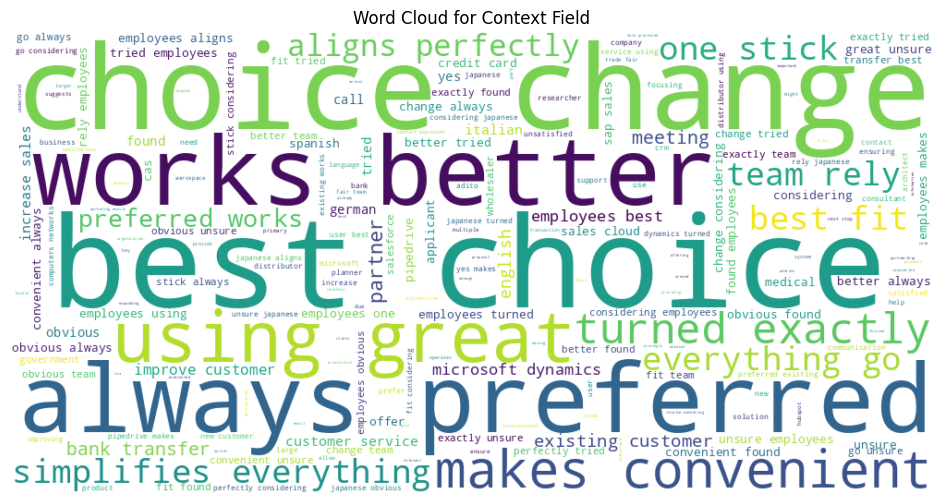

In [ ]:
file_path = "/content/2000single.json"

with open(file_path, "r") as f:
    data = json.load(f)

df = pd.DataFrame(data)

all_context_text = " ".join(df["context"])

stop_words = set(stopwords.words("english"))

words = all_context_text.lower().split()
filtered_words = [word for word in words if word.isalnum() and word not in stopwords.words("english")]
filtered_words = list(dict.fromkeys(filtered_words))

clean_text = " ".join(filtered_words)

wordcloud = WordCloud(width=1000, height=500, background_color="white", colormap="viridis").generate(clean_text)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud for Context Field")
plt.show()

**Most Frequent Words**

<ipython-input-56-74bbc7d607a8>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df_words["Frequency"][:20], y=df_words["Word"][:20], palette="viridis")


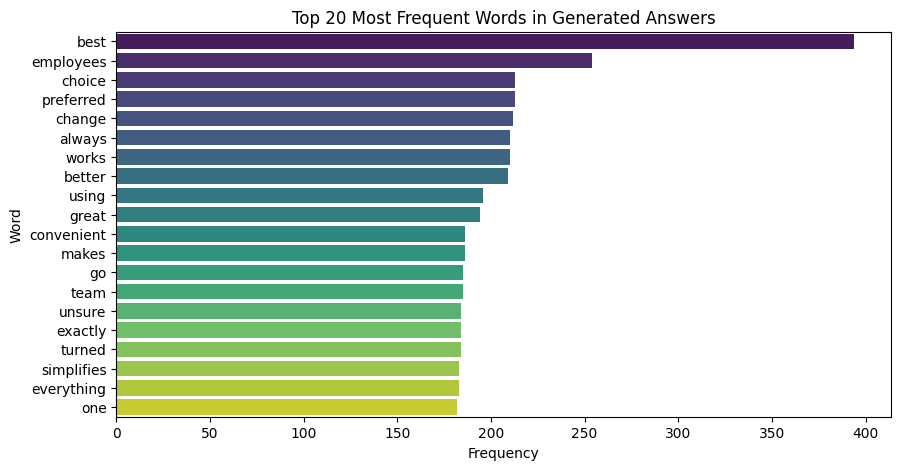

In [ ]:
import seaborn as sns
from collections import Counter

word_counts = Counter(filtered_words)

df_words = pd.DataFrame(word_counts.items(), columns=["Word", "Frequency"]).sort_values(by="Frequency", ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(x=df_words["Frequency"][:20], y=df_words["Word"][:20], palette="viridis")
plt.xlabel("Frequency")
plt.ylabel("Word")
plt.title("Top 20 Most Frequent Words in Generated Answers")
plt.show()

**Bigram Network Graph**

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


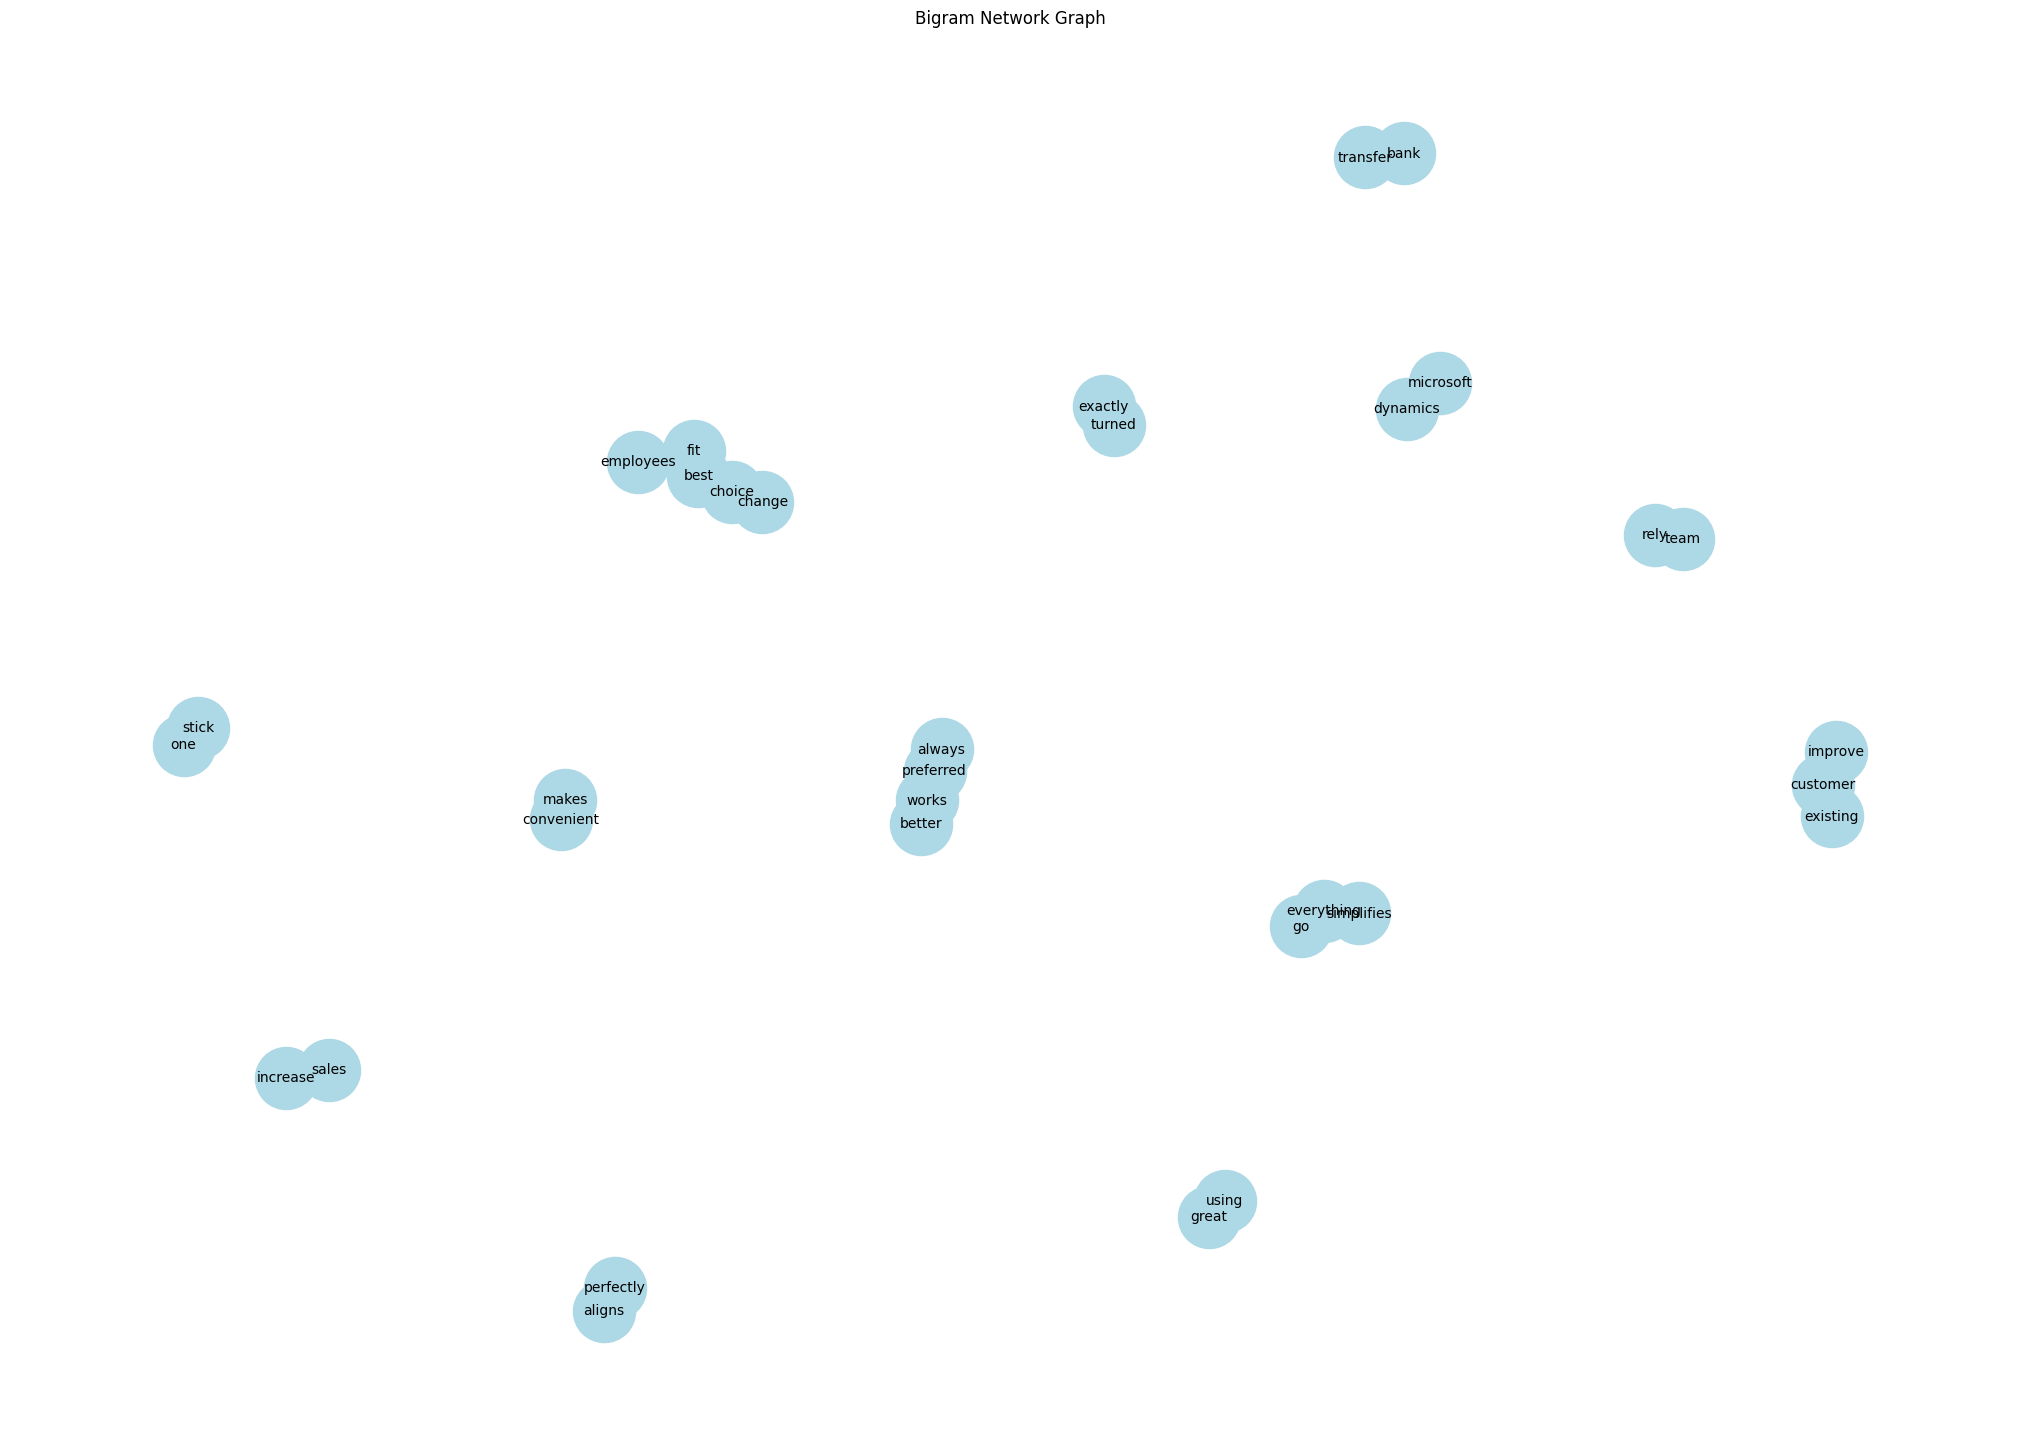

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
from nltk import bigrams, word_tokenize
from collections import Counter
import nltk
import string

nltk.download("punkt")

words = all_context_text.lower().split()
filtered_words = [word for word in words if word.isalnum() and word not in stopwords.words("english")]

bigram_list = list(bigrams(filtered_words))
bigram_counts = Counter(bigram_list)

G = nx.Graph()
for (word1, word2), freq in bigram_counts.most_common(20):
    G.add_edge(word1, word2, weight=freq)

plt.figure(figsize=(14, 10))
pos = nx.spring_layout(G, k=0.8)
nx.draw(
    G, pos, with_labels=False,
    node_color="lightblue", edge_color="gray",
    node_size=3000, font_size=12
)

# Добавляем подписи с небольшим смещением
for node, (x, y) in pos.items():
    plt.text(x, y + 0.05, node, fontsize=12, ha="center", fontweight="bold")

plt.title("Bigram Network Graph", fontsize=14)
plt.show()

### Models evaluation

Given the extensive documentation we have provided, we will only touch on a few points here. Firstly, the performance of the models in our case was strongly related to the size of the dataset.  This was especially true for the multiple selection tasks, where RoBERTa performed very well. For single selection, we can strongly recommend the use of the deBERTa model, as it gave the best results of the three models tested. For text generation, both tested models performed reasonably well.